In [1]:
!git clone https://github.com/sebastianneri/cemexVenturesEnergyEfficiencyModelApp.git

fatal: destination path 'cemexVenturesEnergyEfficiencyModelApp' already exists and is not an empty directory.


In [2]:
!git pull

fatal: not a git repository (or any of the parent directories): .git


# Exploración de la base de datos

In [3]:
import os 
if os.getcwd() != "./cemexVenturesEnergyEfficiencyModelApp/research":
  os.chdir("./cemexVenturesEnergyEfficiencyModelApp/research")

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from Plotting.Plots import getCBoxPlots, getTableOfScatters, removeOutliers, getHeatMap, get3DChart
from sklearn import preprocessing
from ModelEvaluation.ModelsEvaluation import ModelEvaluation
import plotly.figure_factory as ff
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

In [5]:
df = pd.read_csv("datos_tec.csv")

Una vez importados los datos, como sabemos que la mayoría de sus variables son cuantitativas, obtendremos un mapa de correlación, obteniendo el coeficiente de correlación de spearman.

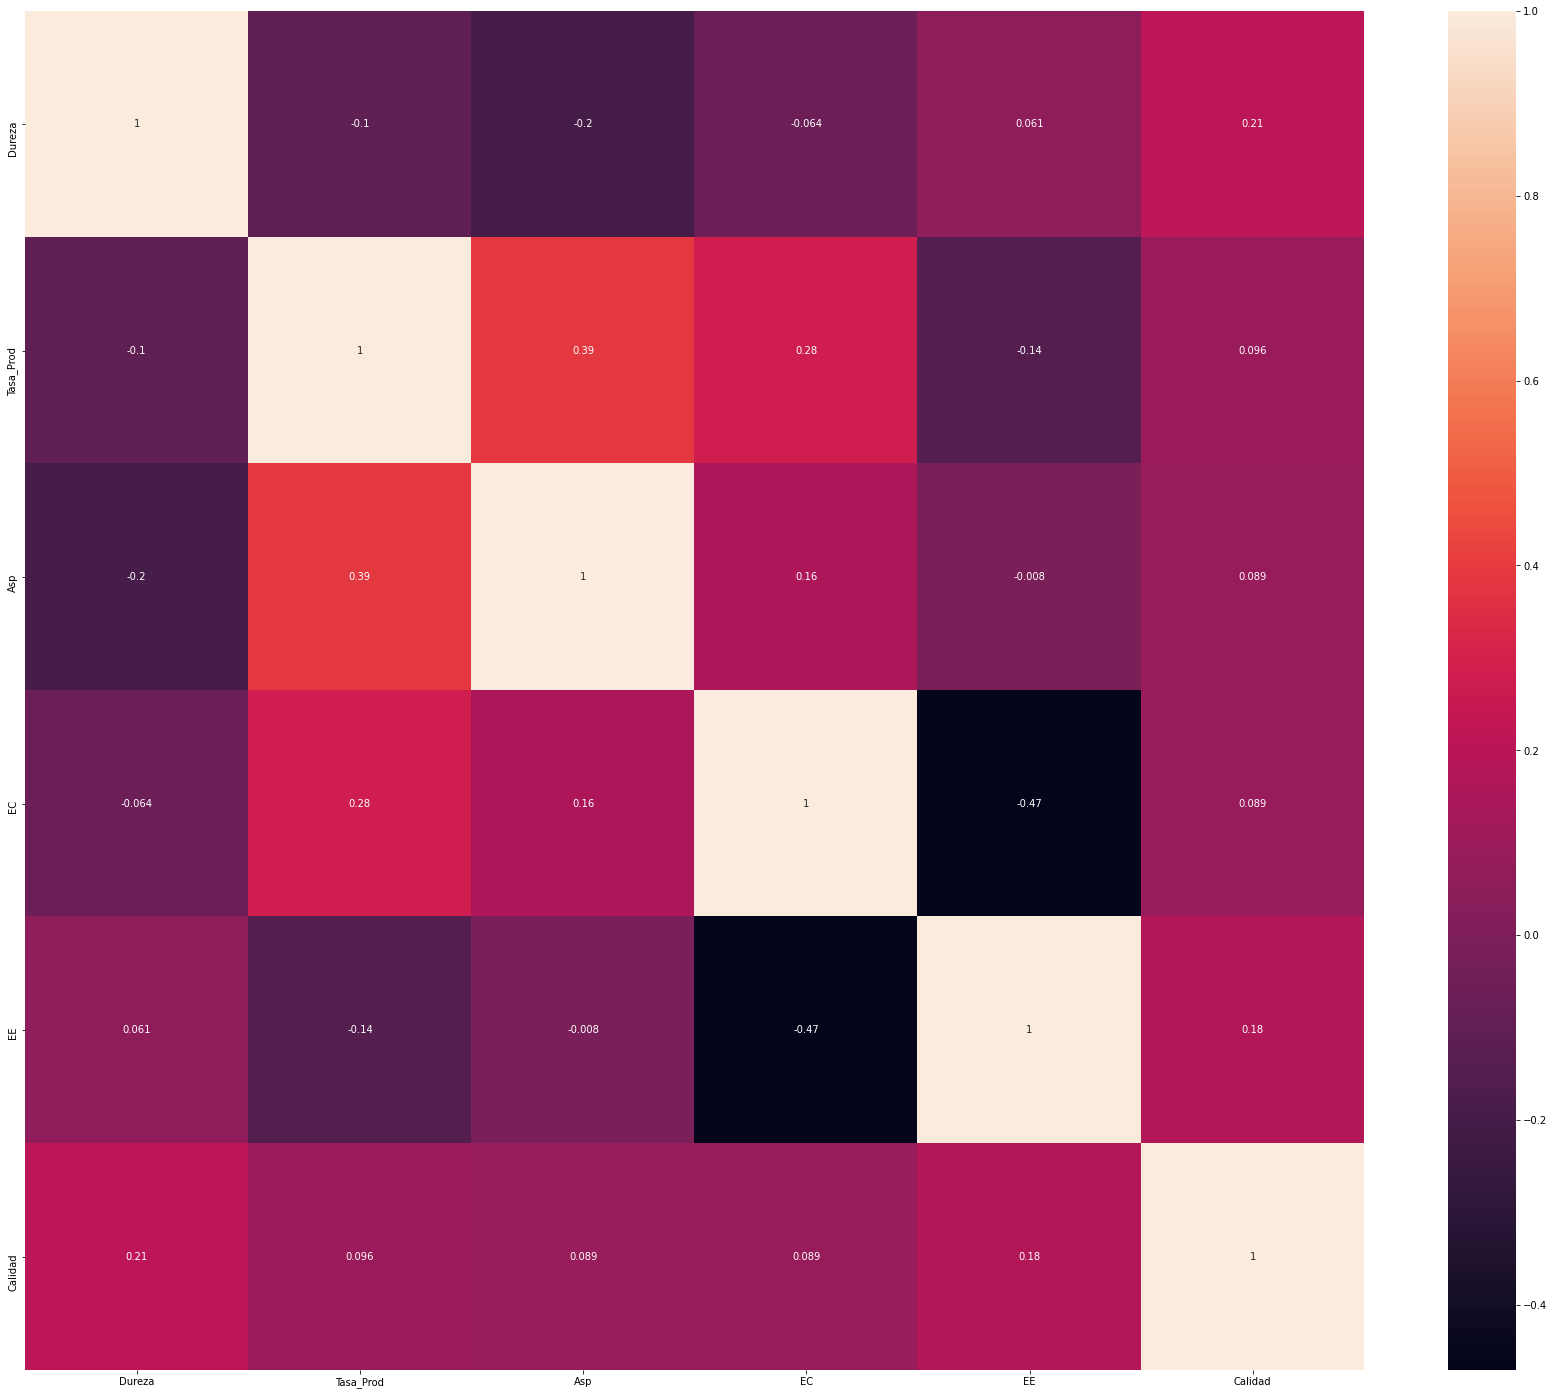

In [6]:
getHeatMap(df, 'spearman')

In [7]:
#getTableOfScatters(df)

Y a continuación se muestran las medidas de dispersión central, no central y de desviación.

In [8]:
df.describe()

,Dureza,Tasa_Prod,Asp,EC,EE,Calidad
count,9391.000000,9392.000000,9391.000000,9392.000000,9392.000000,9392.000000
mean,104.028644,391.005111,3.152306,19.362425,19.059135,0.089891
std,2.049060,43.352777,0.375251,6.698657,8.035162,0.048819
min,80.000000,0.000000,0.090000,0.000000,0.000000,0.000000
25%,103.000000,383.000000,3.040000,15.900000,14.200000,0.061000
50%,104.000000,398.000000,3.260000,19.200000,20.000000,0.081000
75%,105.000000,408.000000,3.380000,23.500000,25.200000,0.107000
max,112.000000,480.000000,3.520000,40.400000,35.300000,1.000000


## Valores nulos

Una vez teniendo la comprensión a rasgos generales de la base de datos, hay que limpiar los valores poco reelevantes para el análisis. En este caso se buscarán los valores que sean nulos en nuestra tabla y se eliminarán las filas que contengan dichos valores.

In [9]:
pd.isna(df).sum()

TIME         0
Dureza       1
Tasa_Prod    0
Asp          1
EC           0
EE           0
Calidad      0
dtype: int64

In [10]:
df.dropna(inplace=True)

In [11]:
pd.isna(df).sum()

TIME         0
Dureza       0
Tasa_Prod    0
Asp          0
EC           0
EE           0
Calidad      0
dtype: int64

Después, se eliminarán las variables que son poco reelevantes para el análisis, como lo es el tiempo y el aspirado.

In [12]:
df = df.drop(["TIME", "Asp"], axis=1)

## Outliers

Una vez eliminados los valores nulos, hay que saber si nuestra tabla contiene **outliers** para eliminarlos y que no cesguen los modelos y resultados obtenidos. Se utilizarán bocplots como visualización para identificarlos de manera máás visual, en este caso será con la función getOutliers.

In [13]:
getCBoxPlots(df, 0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

<Figure size 432x288 with 0 Axes>

En este caso podemos destacar que todas las variables cuentan con outliers, por lo que se eliminarán de todas las comlumnas.

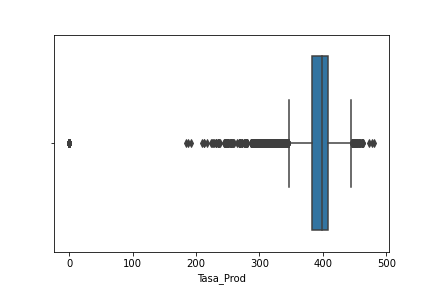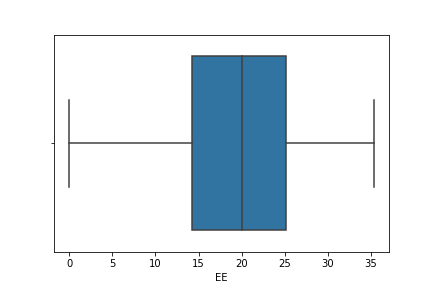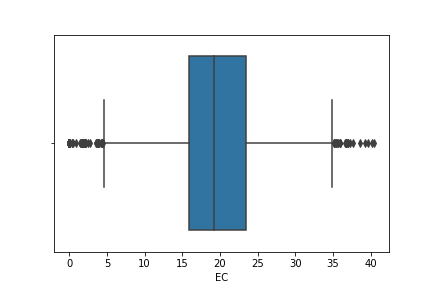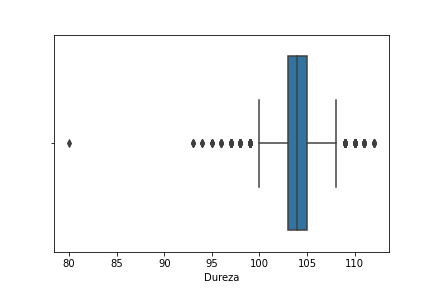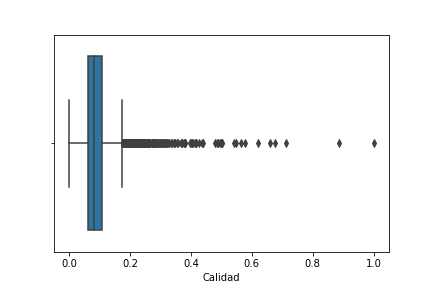


In [14]:
df.shape[0]

9390

In [15]:
df = removeOutliers(df.columns, df)

In [16]:
df["Costo"] = df["EE"] + 0.724 * df["EE"]
df["Costo_TP"] = df["Costo"] / df["Tasa_Prod"]

In [17]:
df.describe()

,Dureza,Tasa_Prod,EC,EE,Calidad,Costo,Costo_TP
count,7913.000000,7913.000000,7913.000000,7913.000000,7913.000000,7913.000000,7913.000000
mean,103.976873,398.091495,20.274005,19.244610,0.083197,33.177708,0.083831
std,1.768688,19.088949,5.250482,7.724014,0.030697,13.316201,0.034425
min,100.000000,344.000000,5.500000,0.000000,0.000000,0.000000,0.000000
25%,103.000000,386.000000,16.600000,14.700000,0.061000,25.342800,0.062081
50%,104.000000,399.000000,19.500000,20.100000,0.080000,34.652400,0.086848
75%,105.000000,410.000000,23.700000,25.100000,0.103000,43.272400,0.110117
max,108.000000,448.000000,34.700000,34.900000,0.173000,60.167600,0.171907


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7913 entries, 0 to 9391
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Dureza     7913 non-null   float64
 1   Tasa_Prod  7913 non-null   int64  
 2   EC         7913 non-null   float64
 3   EE         7913 non-null   float64
 4   Calidad    7913 non-null   float64
 5   Costo      7913 non-null   float64
 6   Costo_TP   7913 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 494.6 KB


Ahora para observar el impacto de los outliers se imprime el mapa de calor con la correlación de spearman.

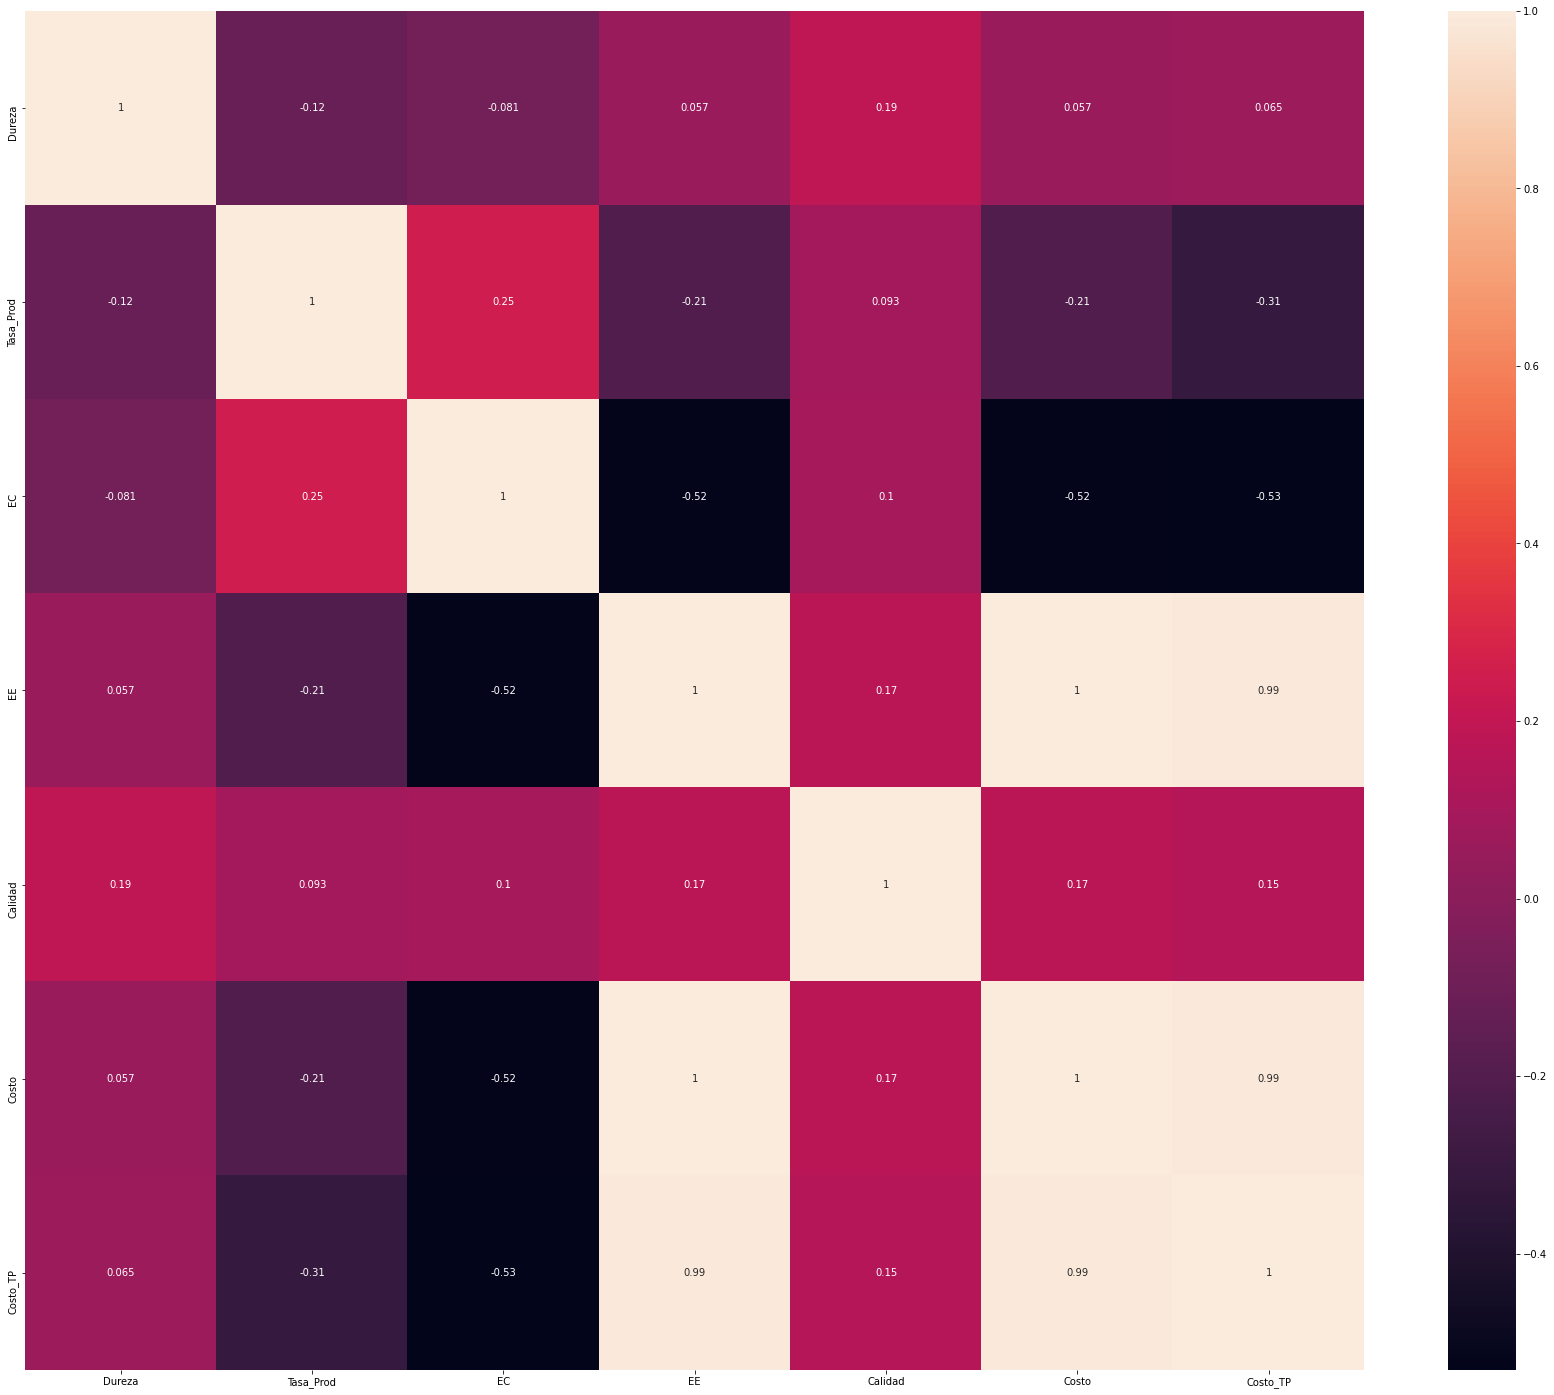

In [19]:
getHeatMap(df, 'spearman')

Se puede ver que aumentaron algunas correlaciones, lo que es bueno para nuestro análisis.

### Distribución de las variables

Para conocer el tipo de variables que tenemos, se imprime la distribución de los datos con los histogramas.

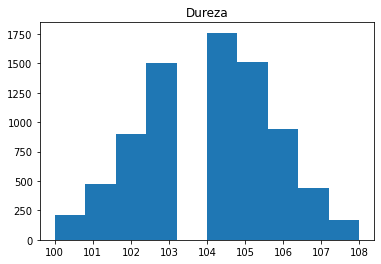

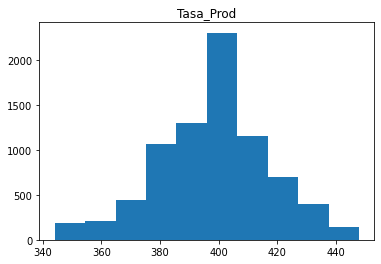

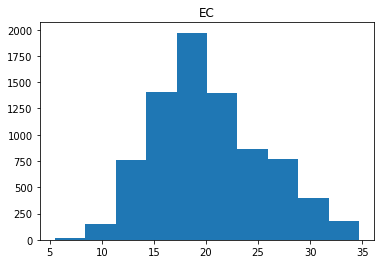

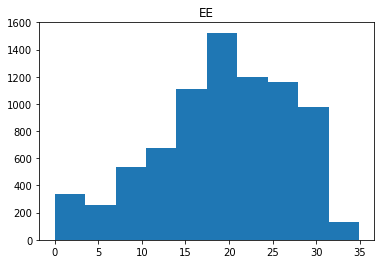

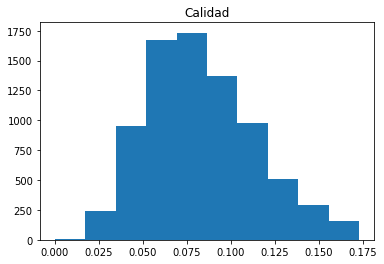

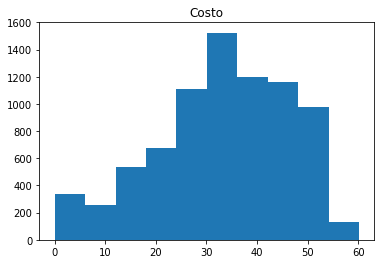

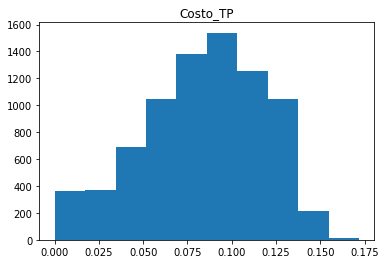

<Figure size 432x288 with 0 Axes>

In [20]:
for i in df.columns:
    plt.hist(df[i])
    plt.title(i)
    plt.show()
    plt.clf()

Ahora se buscaráán outliers restantes para evitar cesgos de cualquier tipo.

In [21]:
getCBoxPlots(df, 1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

<Figure size 432x288 with 0 Axes>

De las cuales podemos destacar las variables de Tasa_Prod y Calidad. En este caso se dejará de lado la variable de energía calórica dado que en el costo no se v e reflejado estos outliers, por lo tanto se permitirá ese grado de error.

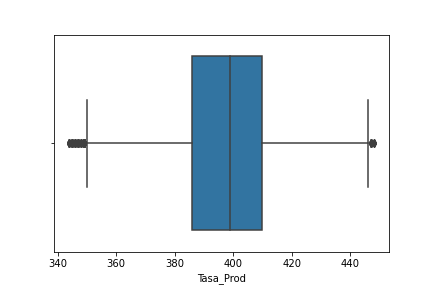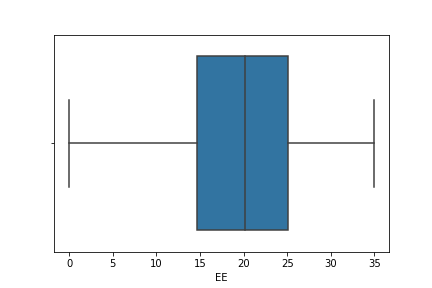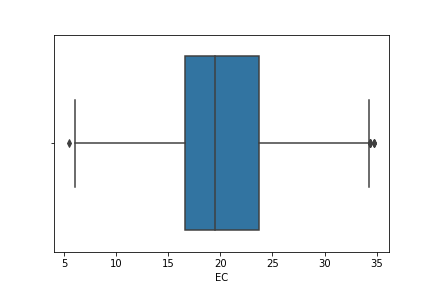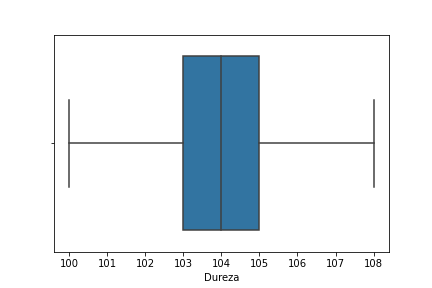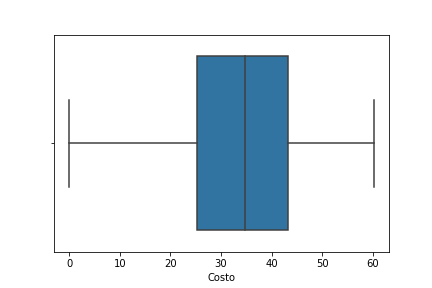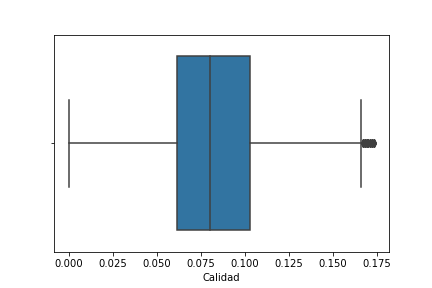

In [22]:
df = removeOutliers(["Tasa_Prod", "Calidad"], df)

In [23]:
df.shape[0]

7758

Una vez eliminados de nuevo los outliers, se verificará si no hay más por eliminar.



In [24]:
getCBoxPlots(df, 2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

<Figure size 432x288 with 0 Axes>

De las siguientes  gráficas podemos destacar la tasa de producción. 

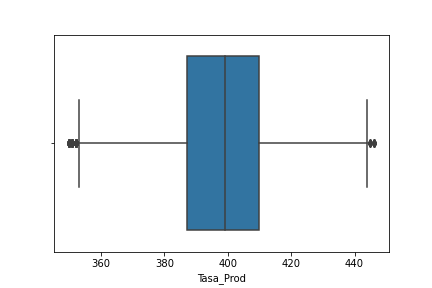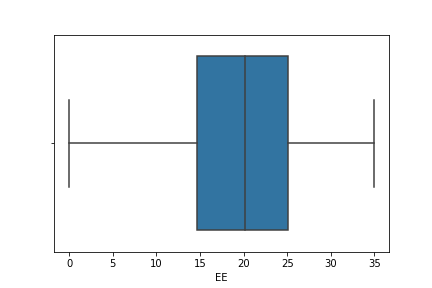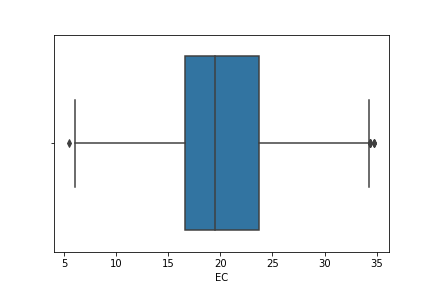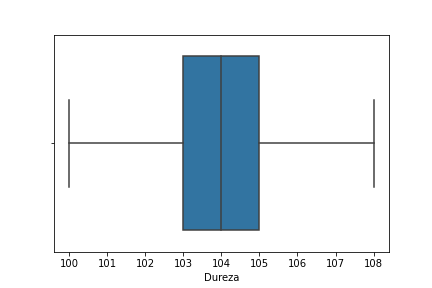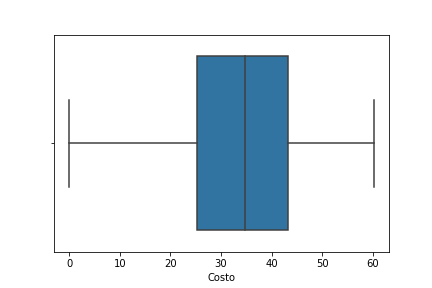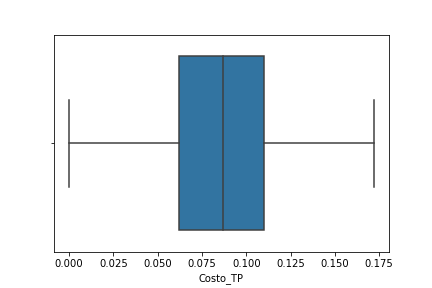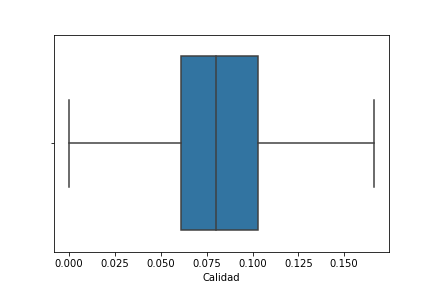

In [25]:
df = removeOutliers(["Tasa_Prod"], df)

Ahora habráá que analizar la tabla de dispersión de las variables para ver de una manera máás visual lo que dicen los datos.

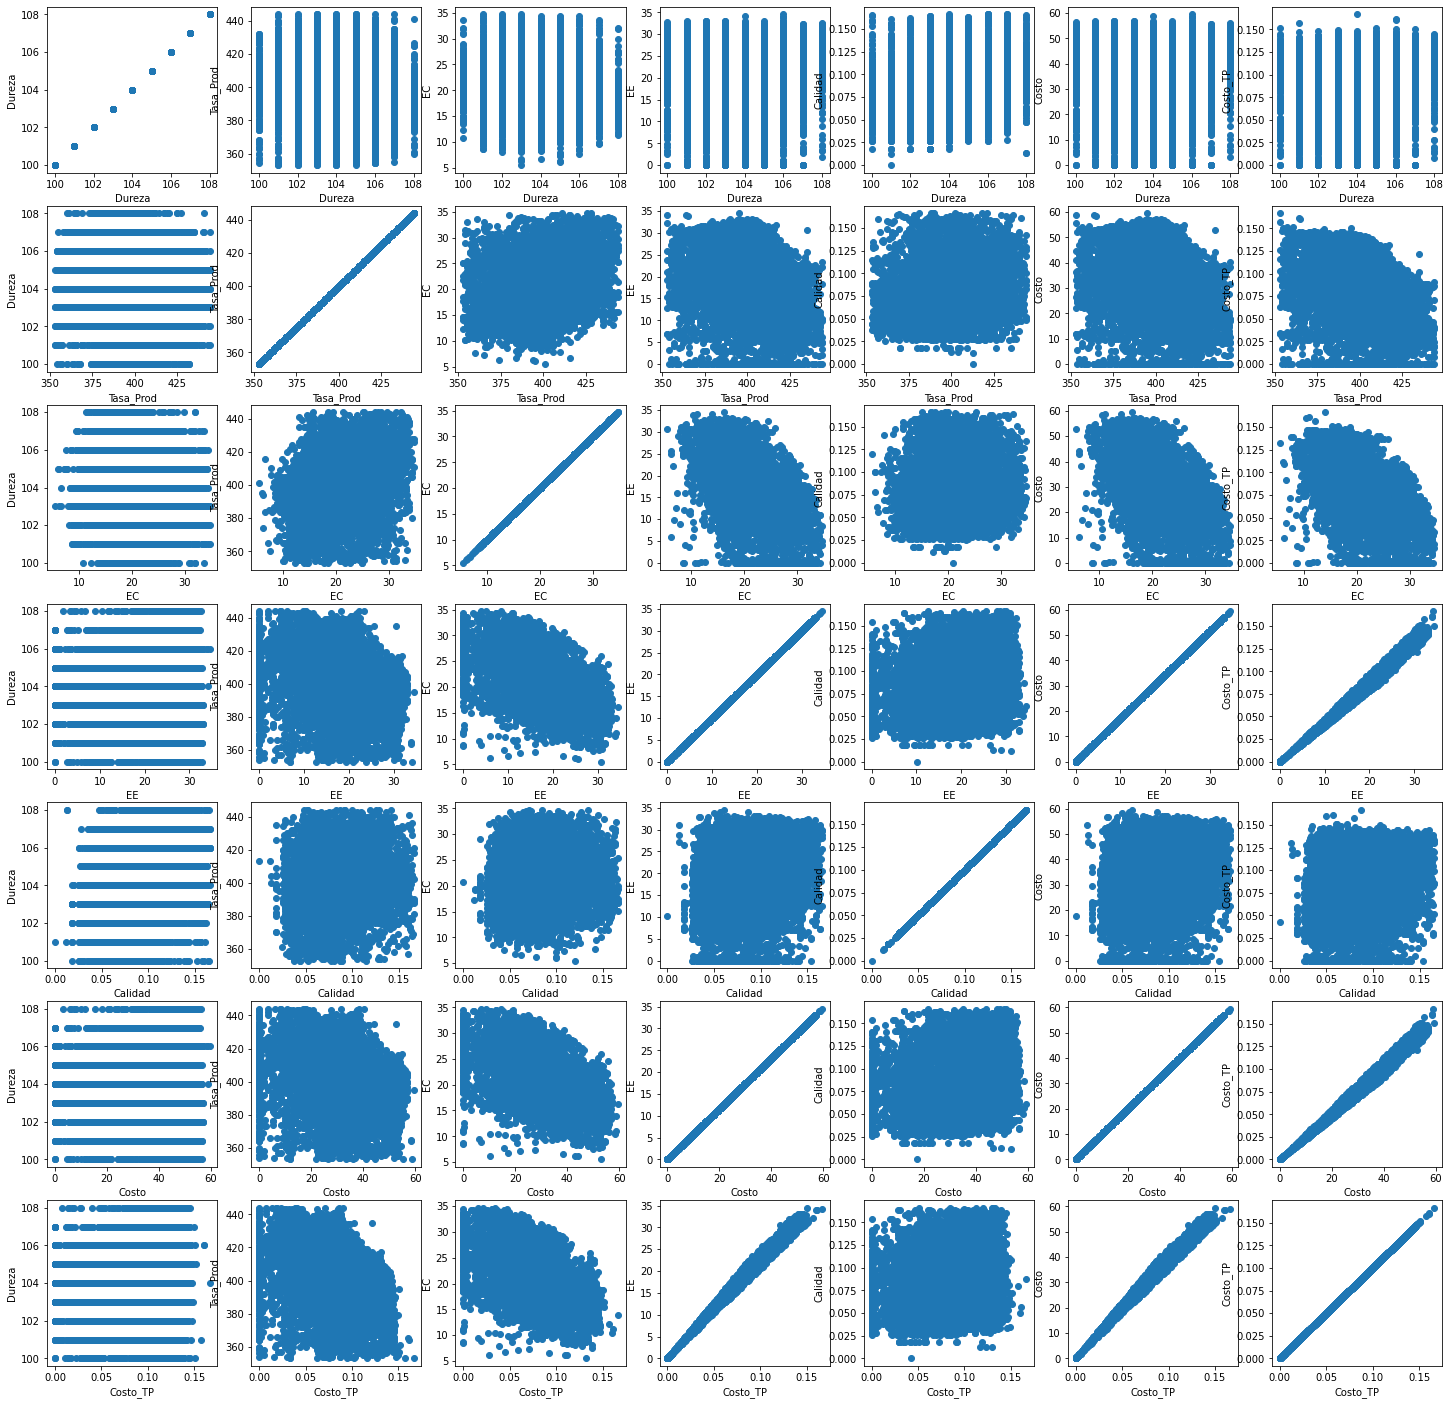

In [26]:
getTableOfScatters(df)

De la tabla de dispersiones realmente no se puede inferir nada en cuanto a la regresióón, pues las variables que se quieren utilzar como independientes no presentan una relación eviente con el costo o el costo ponderado, lo que sí muestran es un comportamiento de clusterizado que es muy evidente.

In [27]:
df.shape[0]

7678

Para finalizar, hay que rectificar que en las variables no hayan máás outliers qué remover.

In [28]:
getCBoxPlots(df, 4)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

<Figure size 432x288 with 0 Axes>

Y efectivamente, confirmamos que nuestras variables se encuentran limpias.

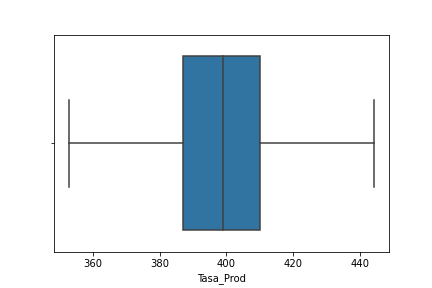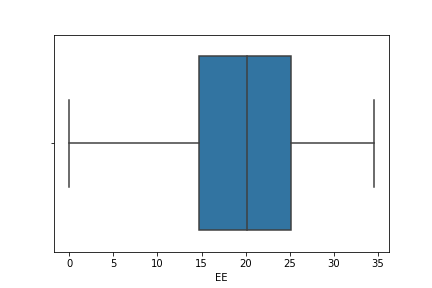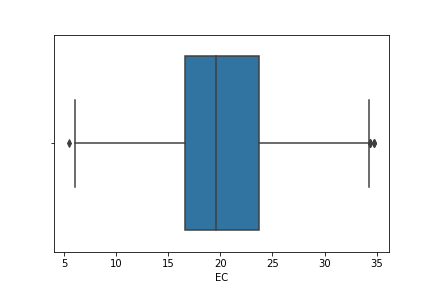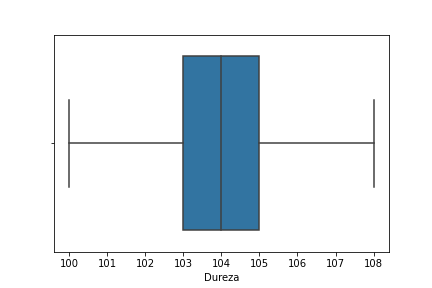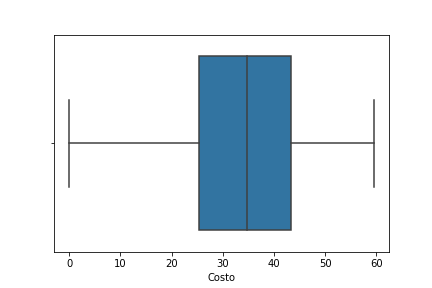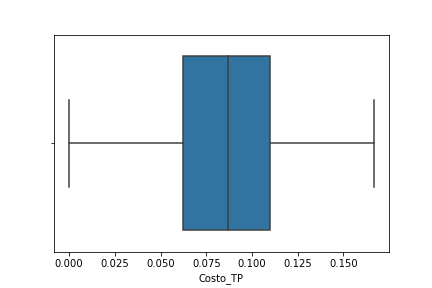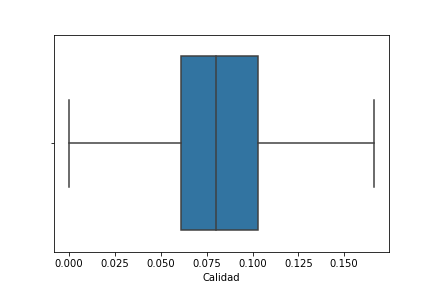

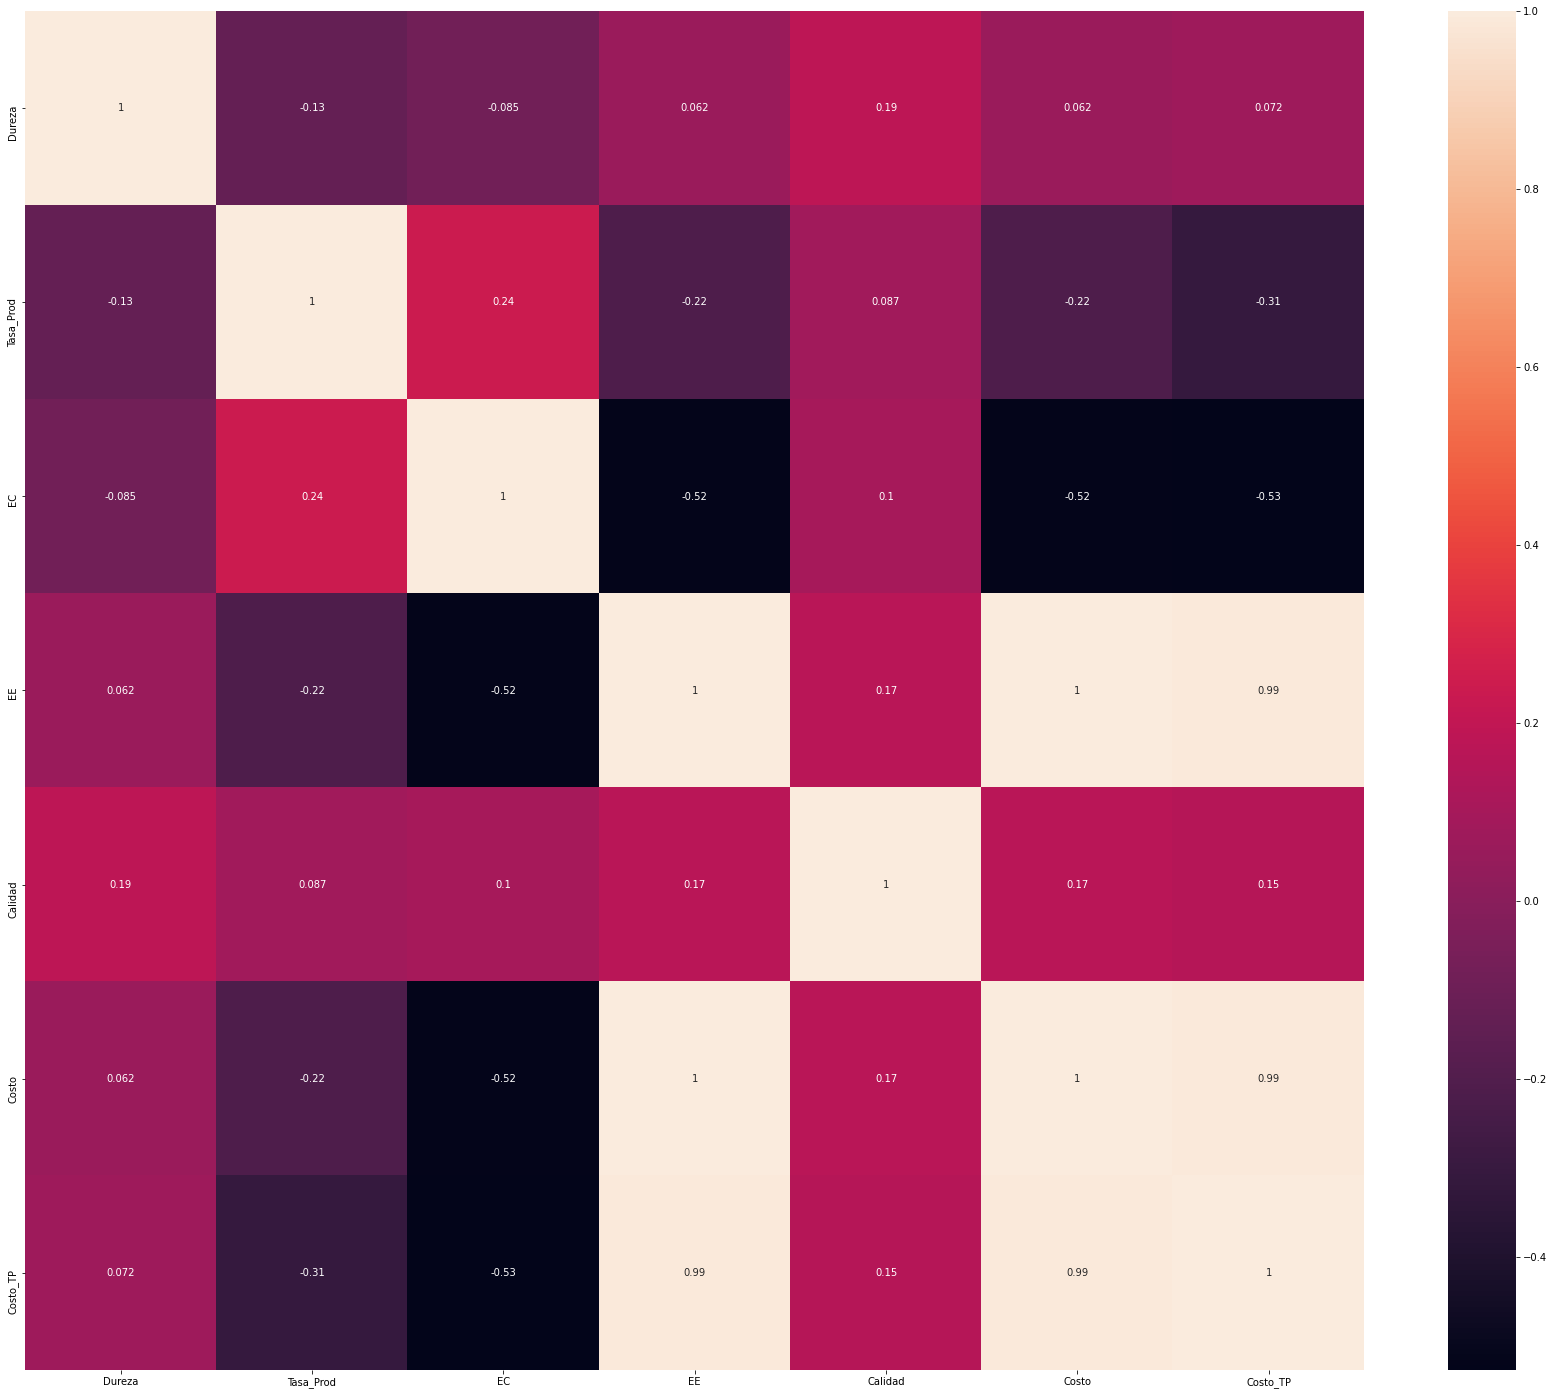

In [29]:
getHeatMap(df, 'spearman')

In [30]:
df.describe()

,Dureza,Tasa_Prod,EC,EE,Calidad,Costo,Costo_TP
count,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000
mean,103.977598,398.962881,20.300000,19.260094,0.082886,33.204402,0.083678
std,1.770989,17.681486,5.232021,7.690175,0.030073,13.257862,0.034132
min,100.000000,353.000000,5.500000,0.000000,0.000000,0.000000,0.000000
25%,103.000000,387.000000,16.600000,14.700000,0.061000,25.342800,0.062100
50%,104.000000,399.000000,19.600000,20.100000,0.080000,34.652400,0.086635
75%,105.000000,410.000000,23.700000,25.100000,0.103000,43.272400,0.109899
max,108.000000,444.000000,34.700000,34.500000,0.166000,59.478000,0.166539


## Visualización 3D

Ahora se realizaráá una visualización 3D de todas las variables para buscar algúúna relación que pueda ser evidente.

In [31]:
get3DChart(df, 10, 2, "3DAllCols")

Archivo en: file:///content/cemexVenturesEnergyEfficiencyModelApp/research/3DCharts/3DAllCols.html


## Estandarización y separación de los datos

Para trabajar con los datos de una manera más sencilla en los modelos, se normalizarán.

In [32]:
sScaler = preprocessing.StandardScaler()

In [33]:
df = pd.DataFrame(sScaler.fit_transform(df), columns=df.columns)
df.head()

,Dureza,Tasa_Prod,EC,EE,Calidad,Costo,Costo_TP
0,-2.246123,-1.751261,-0.993945,1.357653,-0.993863,1.357653,1.624976
1,-2.246123,1.529220,1.261545,-2.504670,0.835159,-2.504670,-2.451745
2,-1.116736,-1.072541,-0.535201,0.954515,-1.060372,0.954515,1.084158
3,0.577343,-0.337261,1.108630,-2.504670,1.832807,-2.504670,-2.451745
4,1.706730,0.228340,1.662946,-2.114536,1.533512,-2.114536,-2.075718


In [34]:
df.describe()

,Dureza,Tasa_Prod,EC,EE,Calidad,Costo,Costo_TP
count,7.678000e+03,7.678000e+03,7.678000e+03,7.678000e+03,7.678000e+03,7.678000e+03,7.678000e+03
mean,-1.717766e-15,-2.993900e-16,1.117185e-15,2.518688e-15,-9.728550e-17,2.032743e-15,4.404092e-17
std,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00
min,-2.246123e+00,-2.599661e+00,-2.828919e+00,-2.504670e+00,-2.756374e+00,-2.504670e+00,-2.451745e+00
25%,-5.520431e-01,-6.766207e-01,-7.072298e-01,-5.930152e-01,-7.278231e-01,-5.930152e-01,-6.322123e-01
50%,1.265007e-02,2.099454e-03,-1.338002e-01,1.092252e-01,-9.597933e-02,1.092252e-01,8.665602e-02
75%,5.773432e-01,6.242596e-01,6.498868e-01,7.594478e-01,6.688841e-01,7.594478e-01,7.682792e-01
max,2.271423e+00,2.547300e+00,2.752462e+00,1.981866e+00,2.763945e+00,1.981866e+00,2.427830e+00


Una vez estandarizados, separaremos las variables que queremos predecir y las que utilizaremos para el entrenamiento del modelo.

In [35]:
Y = df[["EC", "EE", "Costo_TP"]]
X = df[["Dureza", "Tasa_Prod", "Calidad"]]

In [36]:
Y.describe()

,EC,EE,Costo_TP
count,7.678000e+03,7.678000e+03,7.678000e+03
mean,1.117185e-15,2.518688e-15,4.404092e-17
std,1.000065e+00,1.000065e+00,1.000065e+00
min,-2.828919e+00,-2.504670e+00,-2.451745e+00
25%,-7.072298e-01,-5.930152e-01,-6.322123e-01
50%,-1.338002e-01,1.092252e-01,8.665602e-02
75%,6.498868e-01,7.594478e-01,7.682792e-01
max,2.752462e+00,1.981866e+00,2.427830e+00


In [37]:
X.describe()

,Dureza,Tasa_Prod,Calidad
count,7.678000e+03,7.678000e+03,7.678000e+03
mean,-1.717766e-15,-2.993900e-16,-9.728550e-17
std,1.000065e+00,1.000065e+00,1.000065e+00
min,-2.246123e+00,-2.599661e+00,-2.756374e+00
25%,-5.520431e-01,-6.766207e-01,-7.278231e-01
50%,1.265007e-02,2.099454e-03,-9.597933e-02
75%,5.773432e-01,6.242596e-01,6.688841e-01
max,2.271423e+00,2.547300e+00,2.763945e+00


## Clusterización

Analizados los datos, se destacóó el comportamiento de cluster. Esto es reelevante, ya que apartir de esos resultados, planteamos la tésis 

"*De un conjunto de clusters $K$, cada elemento $i_j$ del cluster $K_i$ tendrá características propias de dicho cluster, por lo  que cada clúster tendrá su propio modelo de regresión.*"

Por lo que se utilizará un dendograma para conocer el número de clusters apropiados.

Text(0, 0.5, 'Distancia Euclideana')

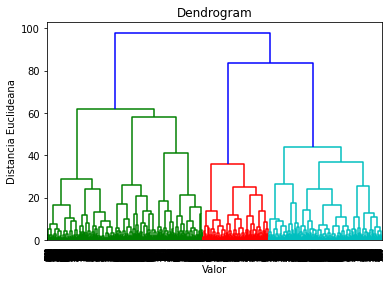

In [38]:
dendogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Valor')
plt.ylabel('Distancia Euclideana')

A partir del dendrograma anterior se utilizará el criterio de obtener el número de líneas por las que pase el trazo de una línea perpedicular en las ramas del dendograma, iniciando justo en el medio de la rama más larga .

El criterio anterior, permite identificar que se pueden dividir perfectamente los datos en 5 clusters, pues estos agrupan de manera más representativa a los datos, dichos clusters se presentan a continuación.

In [39]:
dendogram_pl = ff.create_dendrogram(X, color_threshold=5.5)
dendogram_pl.update_layout(width=800, height=500)
dendogram_pl.show()

Una vez identificados el número de clusters se utilizará el método de clusterizado aglomerativo con la distancia euclideana como criterio de agrupamiento y el algoritmo de minimización de distancias de Ward.

In [40]:
hc = AgglomerativeClustering(n_clusters=5, affinity = 'euclidean', linkage="ward")
y_hc = hc.fit_predict(X)

Los valores que agrupan a cada cluster en este caso se representan de la siguiente manera.

In [41]:
pd.unique(y_hc)

array([0, 4, 3, 2, 1])

Una vez obtenidos los clusters, separaremos el dataframe en los clusters y limpiaremos cada tabla de posibles outliers.

### Cluster 1

In [42]:
cluster1 = df[y_hc == 0]
cluster1.describe()

,Dureza,Tasa_Prod,EC,EE,Calidad,Costo,Costo_TP
count,2598.000000,2598.000000,2598.000000,2598.000000,2598.000000,2598.000000,2598.000000
mean,-0.909595,0.295153,0.042665,-0.085736,-0.551667,-0.085736,-0.116103
std,0.642257,0.789927,1.003811,1.041477,0.749836,1.041477,1.022503
min,-2.246123,-2.543101,-2.695119,-2.504670,-2.756374,-2.504670,-2.451745
25%,-1.116736,-0.224141,-0.649887,-0.801086,-1.160137,-0.801086,-0.834095
50%,-0.552043,0.171780,-0.076457,0.005190,-0.594803,0.005190,-0.038052
75%,-0.552043,0.793940,0.688115,0.746443,0.037040,0.746443,0.701721
max,0.577343,2.547300,2.752462,1.799804,1.566767,1.799804,1.976977


Utilizaremos los box plots para saber si hay outliers o no en nuestra tabla.

In [43]:
getCBoxPlots(cluster1, "C1")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

<Figure size 432x288 with 0 Axes>

De los box plots podemos resaltar la variable de tasa de producción, dejaremos la dureza para la siguiente evaluación de outliers en caso de que la tasa de produccióón contenga estos valores.

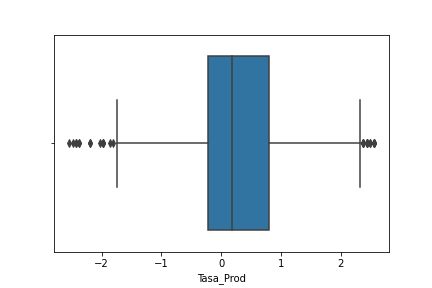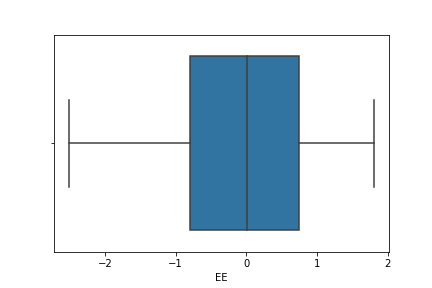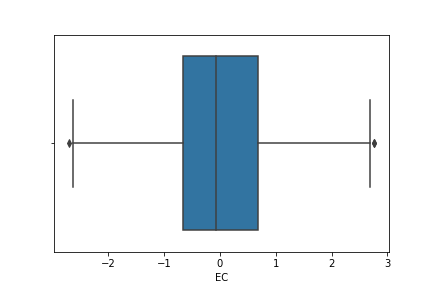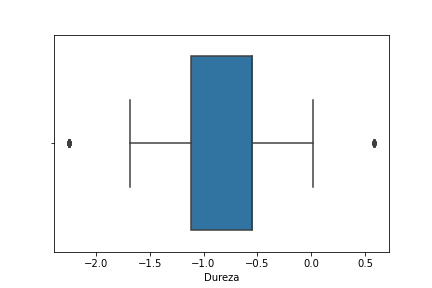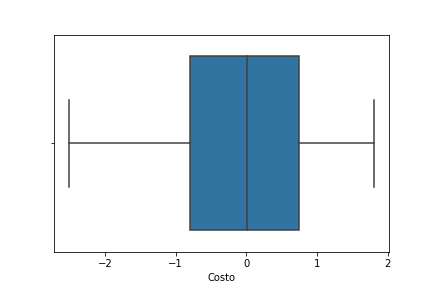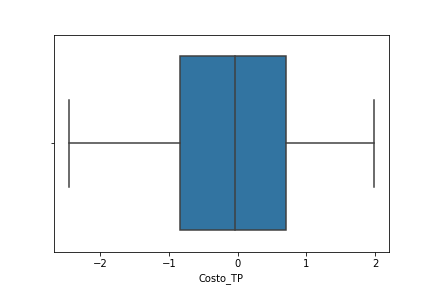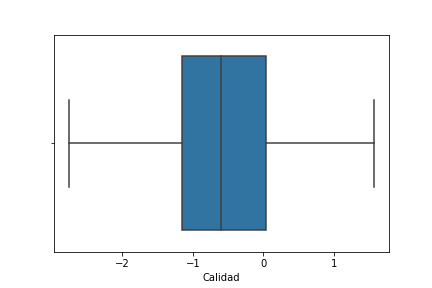

In [44]:
cluster1 = removeOutliers(["Tasa_Prod"], cluster1)

In [45]:
cluster1.shape[0]

2570

In [46]:
getCBoxPlots(cluster1, "C1-2")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

<Figure size 432x288 with 0 Axes>

De las siguientes figuras podemos destacar las de tasa de producción, energíía calórica y dureza.

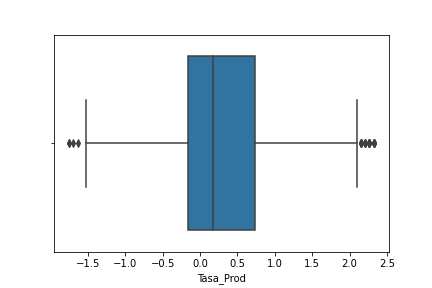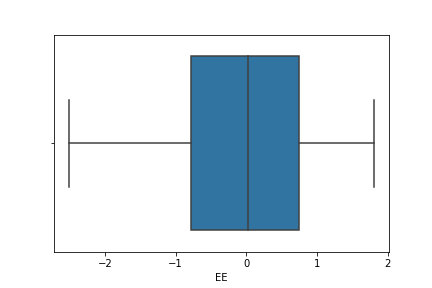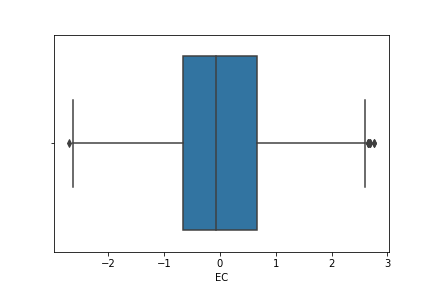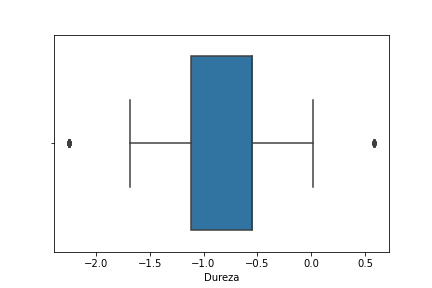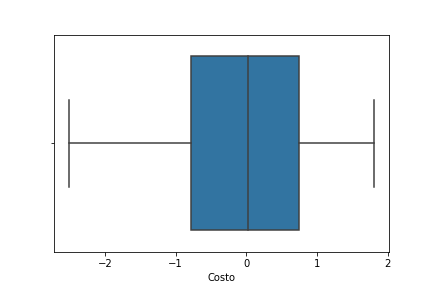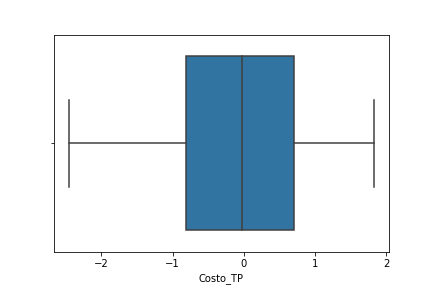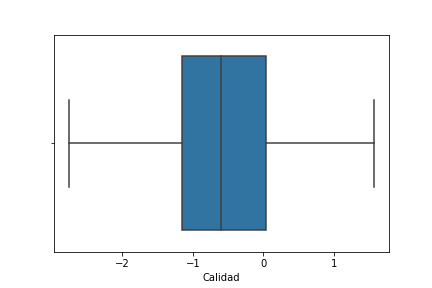

In [47]:
cluster1 = removeOutliers(["Dureza", "EC", "Tasa_Prod"], cluster1)

In [48]:
getCBoxPlots(cluster1, "C1-3")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

<Figure size 432x288 with 0 Axes>

Se consideraron a las siguientes figuras admisibles para su uto, puesto que los outliers que contienenen no parecen tener realmente algúún peso significativo en la tabla y con los que eliminamos en la corrida pasada son suficientes.

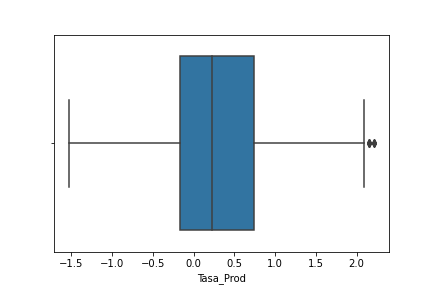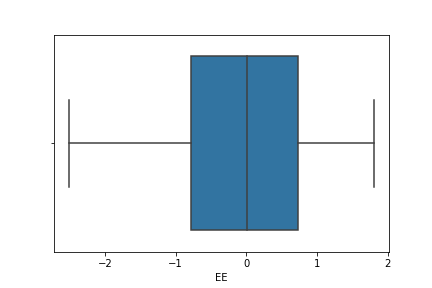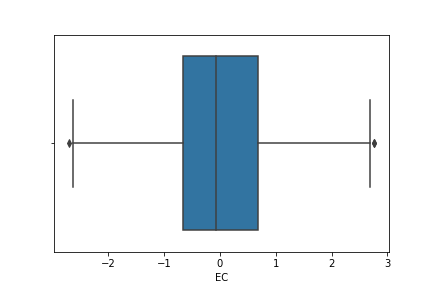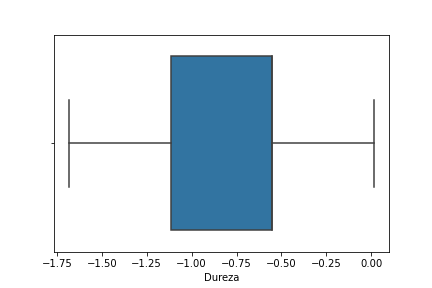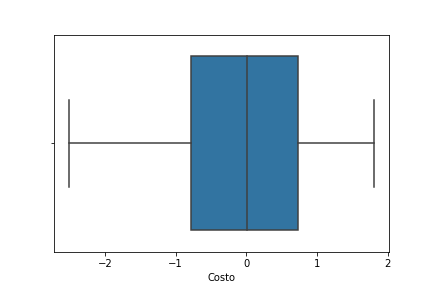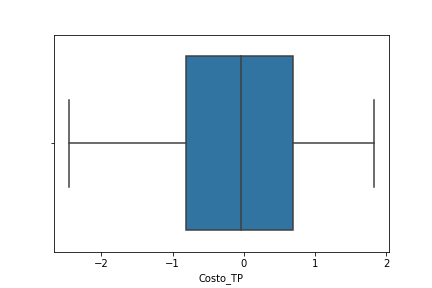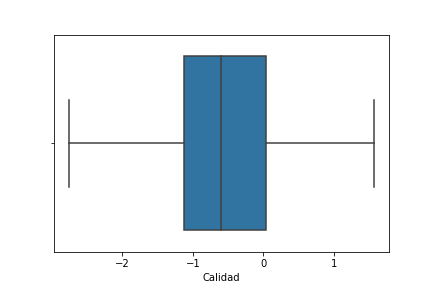

Para finalizar obtendremos el mapa de dispersión de los datos para ver cómo están dispersadas las variables de este primer cluster.

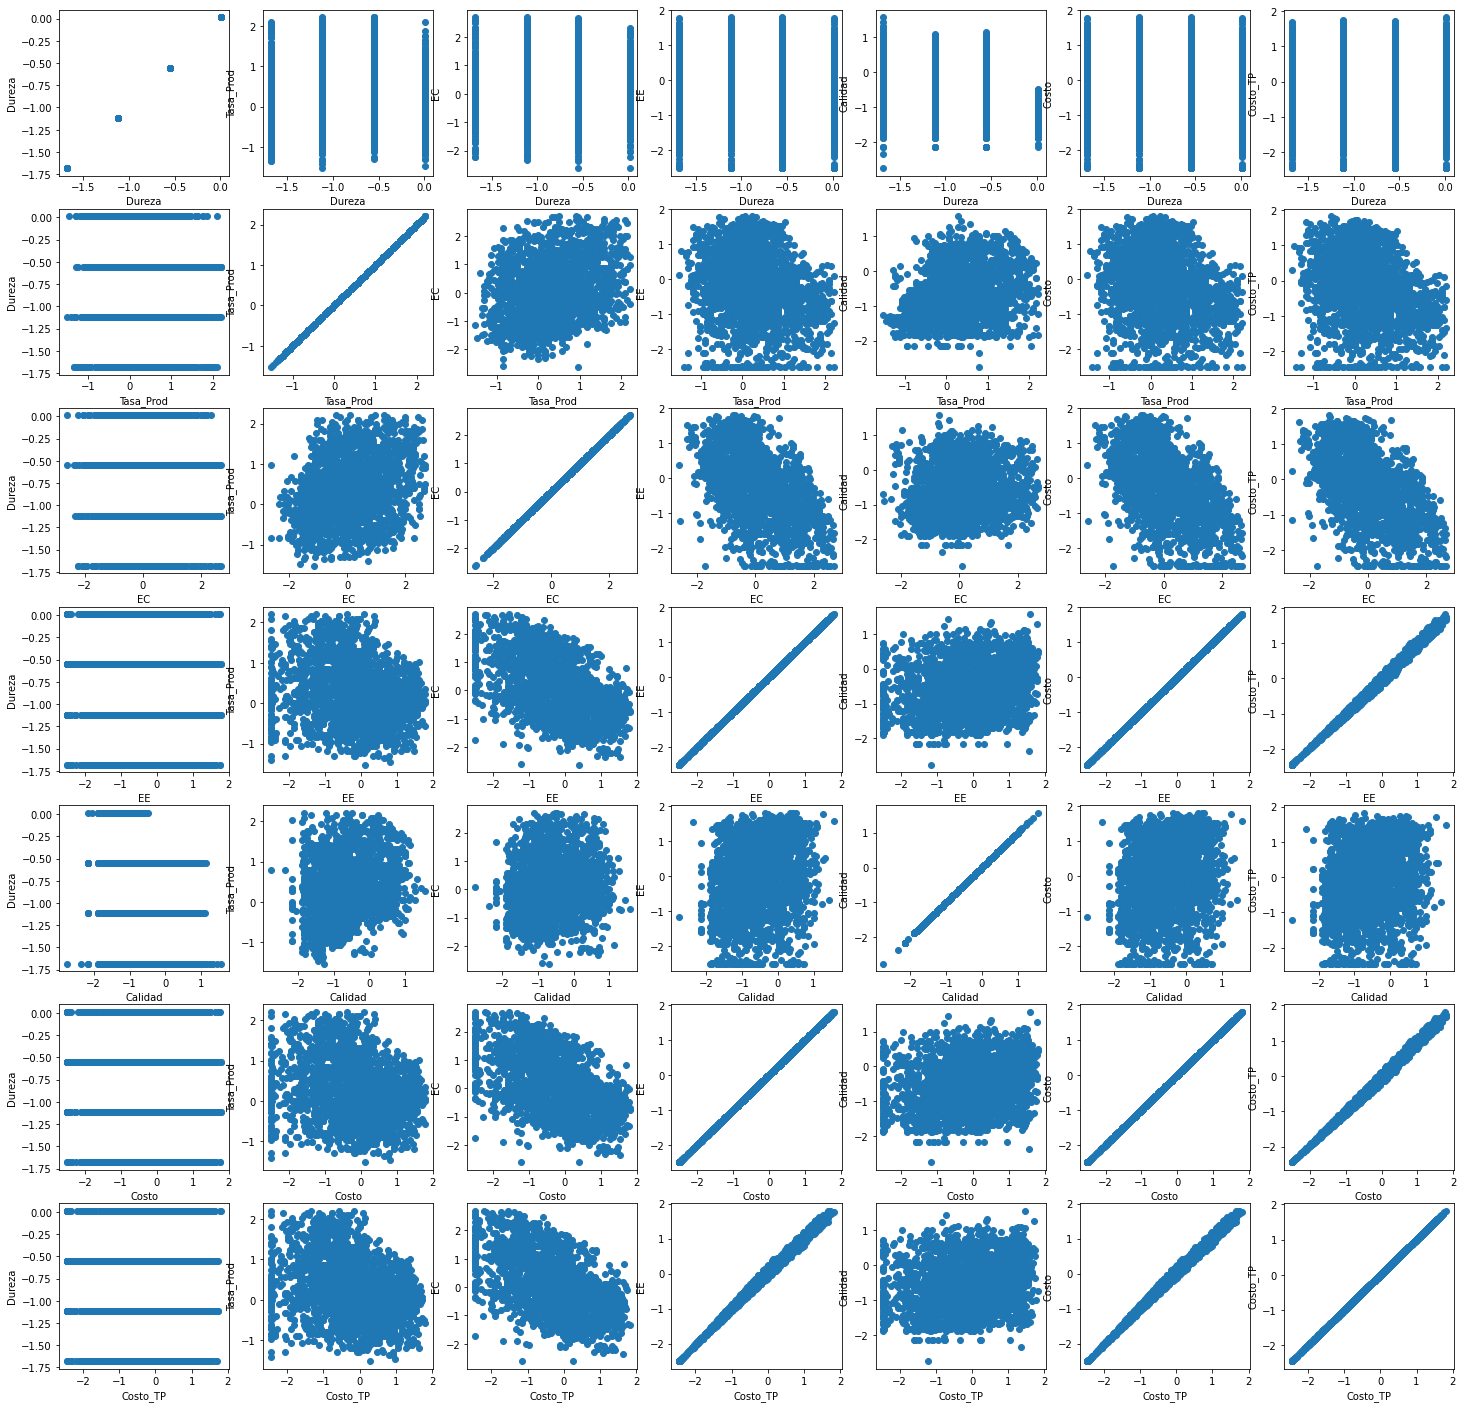

In [49]:
getTableOfScatters(cluster1)

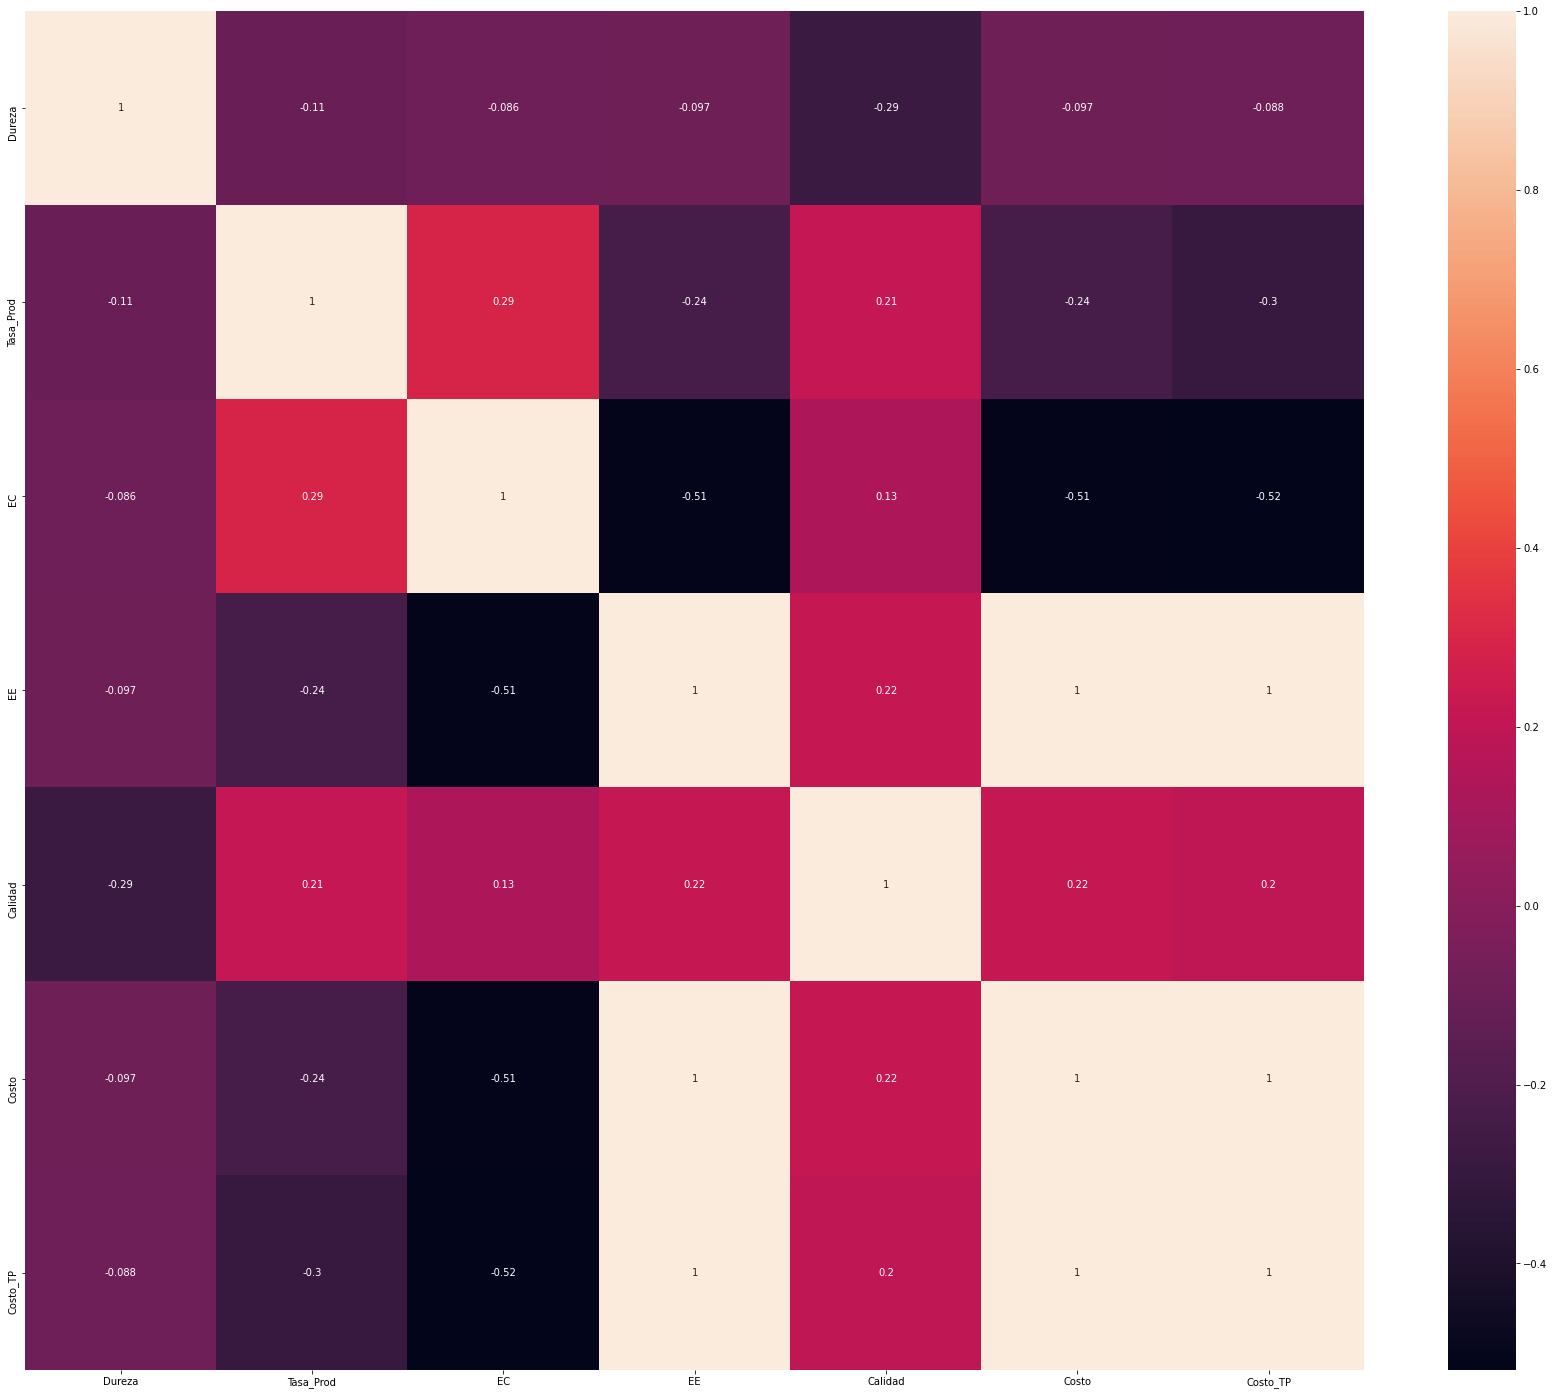

In [50]:
getHeatMap(cluster1, 'spearman')

De la tabla de dispersión y el mapa de calor podemos ver que la tasa de producción y la calidad muestran resultados distintos a los obtenidos de la tabla original, en este caso muestran una correlacióón más alta con el costo ponderado, a continuacióón se calcula el cambio que tuvieron en términos porcentuales todas las variables de la tabla. 

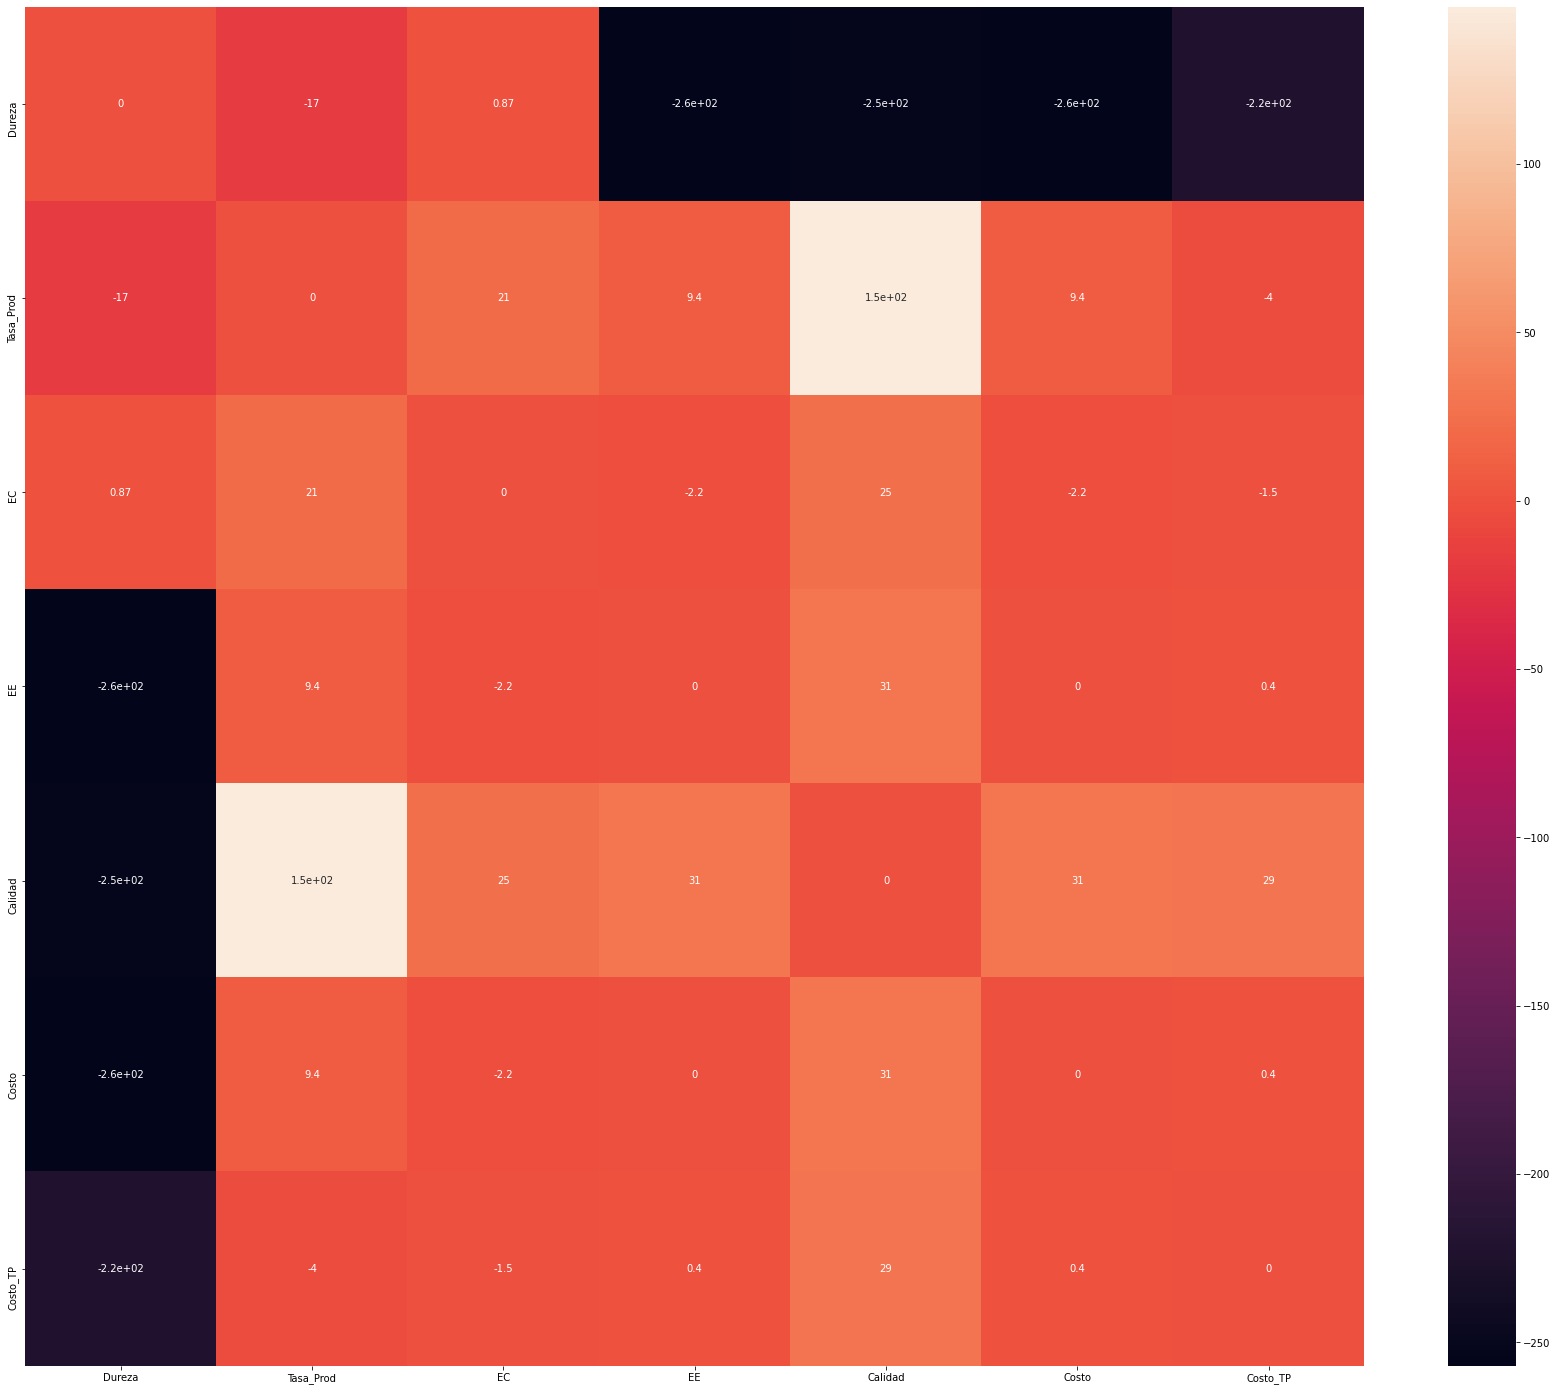

In [66]:
diferencia_porcentual_C1 = (cluster1.corr(method="spearman") - df.corr(method="spearman"))/df.corr(method="spearman") * 100
getHeatMap(diferencia_porcentual_C1, '')

Presentamos a continuación los cambios más reelevantes para el análisis.
* **Energía Calórica**
  * Tasa de producción: +21%
  * Calidad: +25%
  * Tasa de produccióón: +0.87%


* **Energía Eléctrica**
  * Tasa de producción: +9.4%
  * Calidad: +31%
  * Tasa de produccióón: -2.6e+02%


* **Costo por tasa de producción**
  * Tasa de producción: -4%
  * Calidad: +29%
  * Tasa de produccióón: -2.02e+02%

Por lo que podemos concluír que para este cluster, hubo un aumento en la correlación de sus variables independientes con las dependientes, por lo que fue beneficioso para el análisis obtener este cluster para la posterior modelación con regresión.

In [52]:
get3DChart(cluster1, 35, 1, 'Cluster 1 3D')

Archivo en: file:///content/cemexVenturesEnergyEfficiencyModelApp/research/3DCharts/Cluster 1 3D.html


### Cluster 2

In [53]:
cluster2 = df[y_hc == 1]
cluster2.describe()

,Dureza,Tasa_Prod,EC,EE,Calidad,Costo,Costo_TP
count,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000
mean,-0.045016,0.703324,0.293620,-0.061587,1.408983,-0.061587,-0.125383
std,0.812941,0.961070,0.985595,1.007883,0.621895,1.007883,0.999392
min,-2.246123,-2.543101,-2.828919,-2.504670,0.003785,-2.504670,-2.451745
25%,-0.552043,0.002099,-0.420515,-0.667791,0.934924,-0.667791,-0.730706
50%,0.012650,0.567700,0.114686,0.057207,1.367238,0.057207,-0.073239
75%,0.577343,1.529220,1.051288,0.678170,1.866062,0.678170,0.630270
max,2.271423,2.547300,2.752462,1.786799,2.763945,1.786799,1.778888


In [54]:
getCBoxPlots(cluster2, "C2")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

<Figure size 432x288 with 0 Axes>

De las siguientes figuras, sóólo la tasa de producción contiene outliers representativos, por lo que se removerán de la table de este cluster.

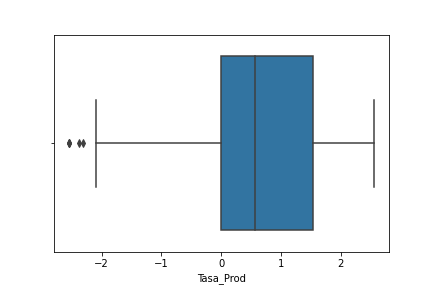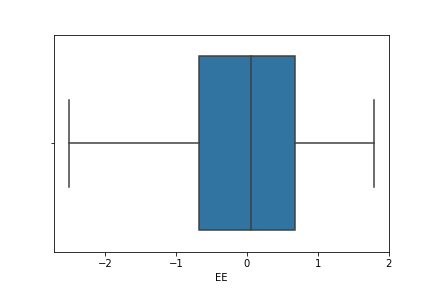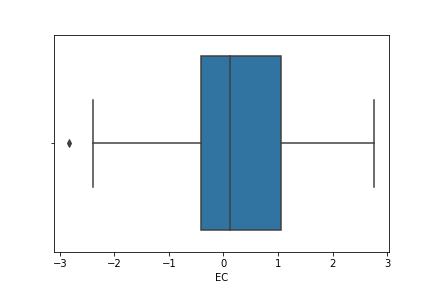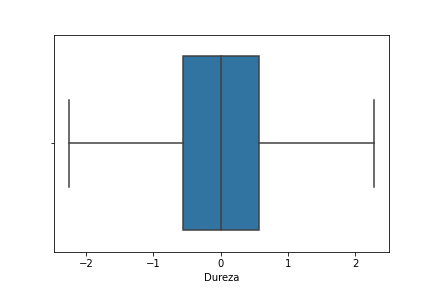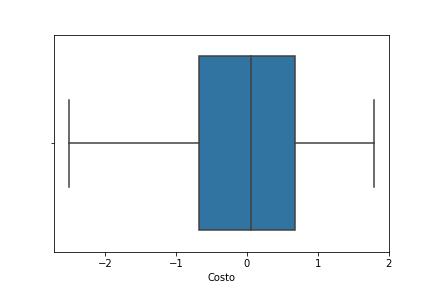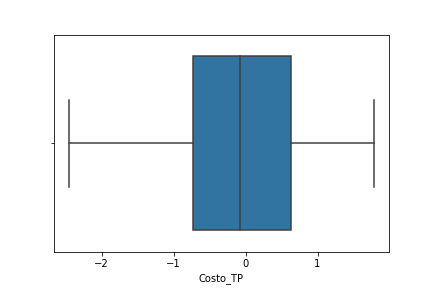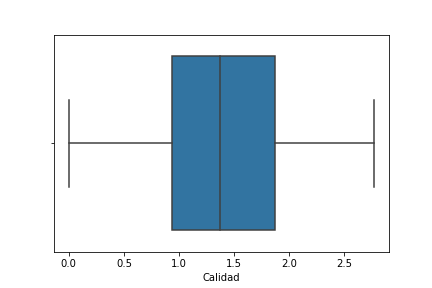

In [55]:
cluster2 = removeOutliers(["Tasa_Prod"], cluster2)

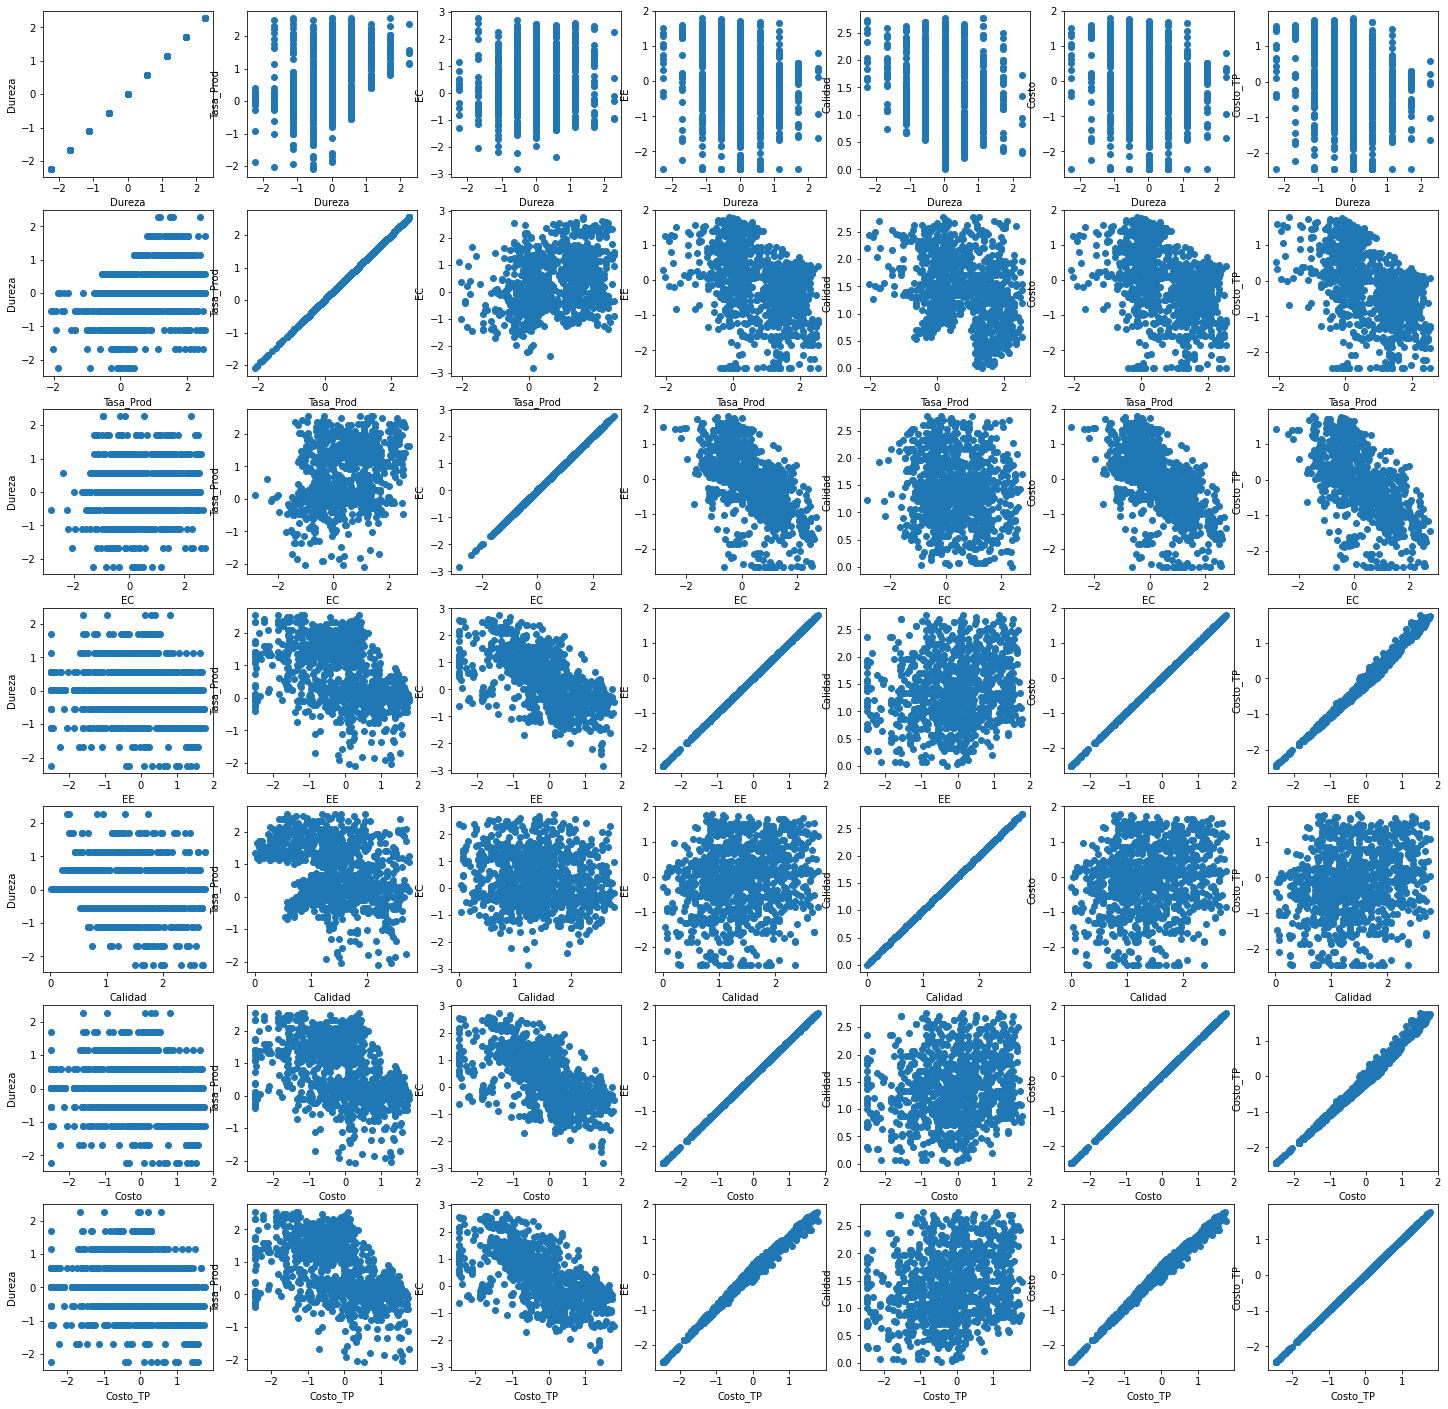

In [56]:
getTableOfScatters(cluster2)

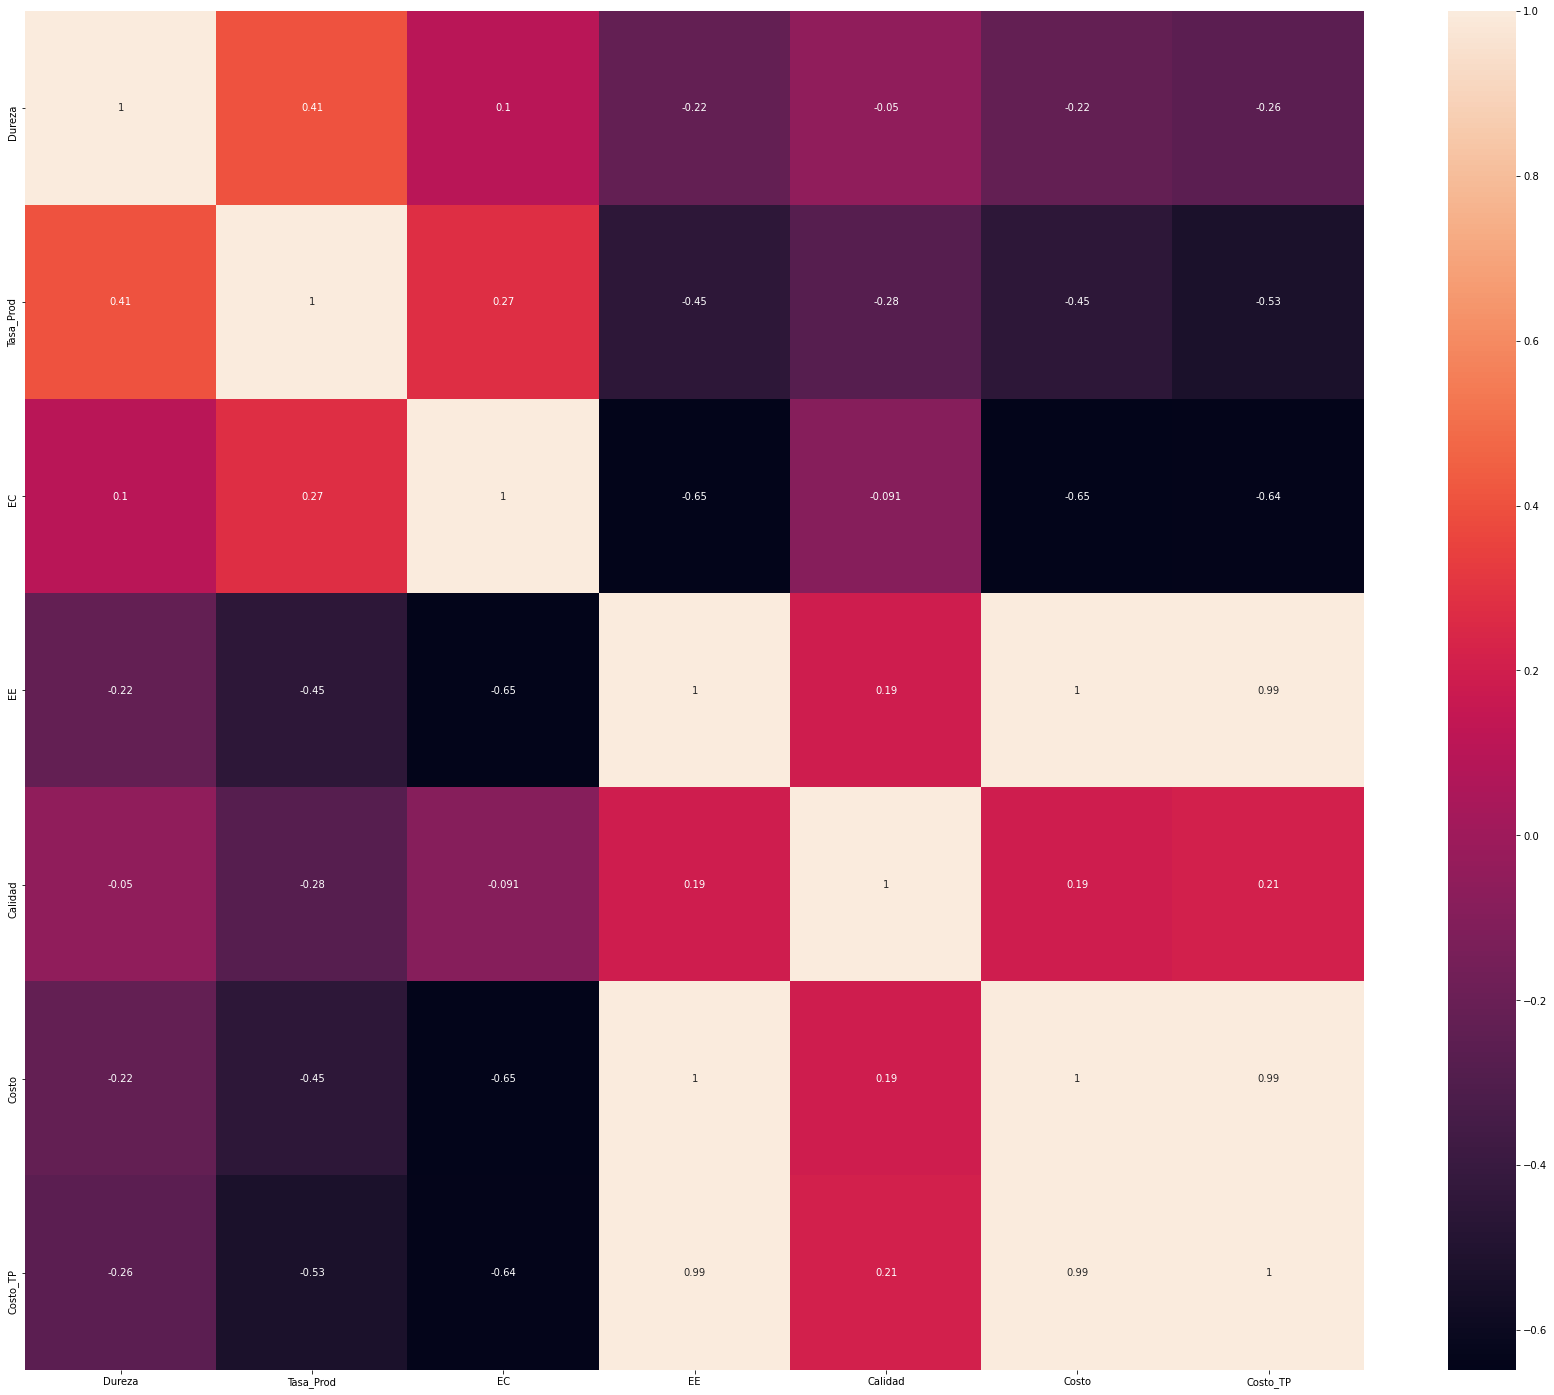

In [57]:
getHeatMap(cluster2, 'spearman')

In [58]:
get3DChart(cluster2, 28, 2 , 'Cluster 2 3D')

IndexError: ignored

In [ ]:
XC2 = cluster2[X.columns]
YC2 = cluster2["ET"]

### Cluster 3

In [ ]:
cluster3 = df[y_hc == 2]
cluster3.describe()

In [ ]:
getCBoxPlots(cluster3, "C3")

In [ ]:
getTableOfScatters(cluster3)

In [ ]:
getHeatMap(cluster3, 'spearman')

In [ ]:
get3DChart(cluster3, 28, 2 , 'Cluster 3 3D')

### Cluster 4

In [ ]:
cluster4 = df[y_hc == 3]
cluster4.describe()

In [ ]:
getCBoxPlots(cluster4, "C4")

In [ ]:
cluster4 = removeOutliers(["Tasa_Prod", "Dureza"], cluster4)

In [ ]:
cluster4.describe()

In [ ]:
getCBoxPlots(cluster4, "C4-1")

In [ ]:
getTableOfScatters(cluster4)

In [ ]:
getHeatMap(cluster4, 'spearman')

In [ ]:
get3DChart(cluster4, 28, 2 , 'Cluster 4 3D')

### Cluster 5

In [ ]:
cluster5 = df[y_hc == 4]
cluster5.describe()

In [ ]:
getCBoxPlots(cluster5, "C5")

In [ ]:
cluster5 = removeOutliers(["Costo", "Calidad"], cluster5)

In [ ]:
getTableOfScatters(cluster5)

In [ ]:
getHeatMap(cluster5, 'spearman')

In [ ]:
get3DChart(cluster5, 28, 2 , 'Cluster 5 3D')

## Optimización de los datos


### Cluster 1

In [ ]:
cluster1.describe()

In [ ]:
import scipy.stats as st
conf = st.norm.interval(0.95, loc=np.mean(cluster1["Costo_TP"]), scale=np.std(cluster1["Costo_TP"])/np.sqrt(cluster1.shape[0]) )
conf

In [ ]:
cluster1.loc[cluster1["Costo_TP"].between(conf[0], conf[1])].shape

## Regresión

In [ ]:
clusters = [cluster1, cluster2, cluster3, cluster4, cluster5]

In [ ]:
x_cols = ["Tasa_Prod", "Dureza", "Calidad"]
y_cols = ["Costo_TP"]
#ME = ModelEvaluation(clusters, x_cols, y_cols, 1000)

In [ ]:
from itertools import combinations
df_combinations = len(list(combinations(df.columns, 3)))
df_combinations

In [ ]:
import os
os.popen('gnome-screensaver-command --lock')

In [ ]:
df.head()